# An intro to quantum machine learning 🚀
(with one qubit!)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


Since we will only use one qubit, we need to reduce the dimensionality of the data. For this, we will use Kernel PCA.

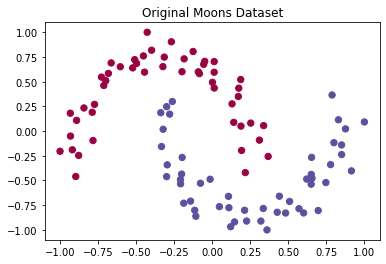

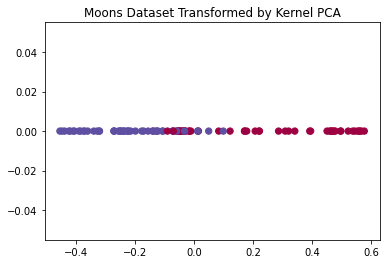

In [12]:
n_samples = 100

# Create the dataset
X, y = make_moons(n_samples=n_samples, noise=0.1, random_state=42)

# Preprocess the dataset
scaler = MinMaxScaler((-1, 1))
X = scaler.fit_transform(X)

# Apply Kernel PCA
kpca = KernelPCA(n_components=1, kernel='rbf', gamma=15)
X_kpca = kpca.fit_transform(X)

# Plot the original dataset
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Original Moons Dataset")

# Plot the transformed dataset
plt.figure()
plt.scatter(X_kpca, np.zeros_like(X_kpca), c=y, s=40, cmap=plt.cm.Spectral)
plt.title("Moons Dataset Transformed by Kernel PCA")

plt.show()


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_kpca, y, test_size=0.3, random_state=42)

## Variational Quantum Classifier

In [5]:
from qiskit_machine_learning.algorithms import VQC
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap

In [6]:
num_qubits = 1
feature_map = ZFeatureMap(feature_dimension=1, reps=1)
print(feature_map.decompose())

   ┌───┐┌─────────────┐
q: ┤ H ├┤ P(2.0*x[0]) ├
   └───┘└─────────────┘


In [7]:
var_form = TwoLocal(num_qubits, ['rz', 'ry'], 'cz', reps=3, insert_barriers=True)
print(var_form.decompose())

   ┌──────────┐┌──────────┐ ░  ░ ┌──────────┐┌──────────┐ ░  ░ ┌──────────┐»
q: ┤ Rz(θ[0]) ├┤ Ry(θ[1]) ├─░──░─┤ Rz(θ[2]) ├┤ Ry(θ[3]) ├─░──░─┤ Rz(θ[4]) ├»
   └──────────┘└──────────┘ ░  ░ └──────────┘└──────────┘ ░  ░ └──────────┘»
«   ┌──────────┐ ░  ░ ┌──────────┐┌──────────┐
«q: ┤ Ry(θ[5]) ├─░──░─┤ Rz(θ[6]) ├┤ Ry(θ[7]) ├
«   └──────────┘ ░  ░ └──────────┘└──────────┘


In [8]:
optimizer = SPSA(maxiter=40)
vqc = VQC(num_qubits, 
        feature_map, 
        ansatz = var_form, 
        loss = 'cross_entropy',
        optimizer = optimizer, 
)

In [14]:
vqc.fit(X_train, y_train)

In [15]:
test_accuracy = vqc.score(X_test, y_test)
print(f'Testing success ratio: {test_accuracy}')

Testing success ratio: 0.7333333333333333


In [18]:
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch

QiskitError: 'Key 2 is greater than Statevector dimension 2.'

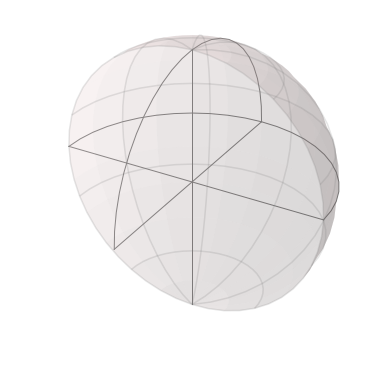

In [26]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

def plot_dataset_on_bloch_sphere(model, X, y):
    feature_map = ZFeatureMap(feature_dimension=1, reps=1)
    simulator = StatevectorSimulator()
    bloch_sphere = Bloch()

    for i, point in enumerate(X):
        true_label = y[i]
        circuit = QuantumCircuit(1)
        circuit.append(feature_map.bind_parameters({feature_map.parameters[0]: point[0]}), [0])
        transpiled_circuit = transpile(circuit, simulator)
        statevector = Statevector(simulator.run(transpiled_circuit).result().get_statevector())
        bloch_sphere.add_vectors(statevector)

    bloch_sphere.show()

plot_dataset_on_bloch_sphere(None, X, y)


In [21]:
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import StatevectorSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector

def plot_dataset_on_bloch_sphere(model, X, y):
    feature_map = ZFeatureMap(feature_dimension=1, reps=1)
    simulator = StatevectorSimulator()
    bloch_sphere = Bloch()

    for i, point in enumerate(X):
        true_label = y[i]
        circuit = QuantumCircuit(1)
        circuit.append(feature_map, [0], point)
        transpiled_circuit = transpile(circuit, simulator)
        statevector = Statevector(simulator.run(transpiled_circuit).result().get_statevector())
        bloch_sphere.add_state(statevector)

    bloch_sphere.show()

plot_dataset_on_bloch_sphere(None, X, y)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()